In this project, we aim to automate the process of assessing individuals' eligibility for loans based on account holder information.

## Read Data

Our dataset consists of 614 rows, representing individual accounts, with 11 columns containing their information and 1 column indicating whether they are eligible or not.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
loan_data = pd.read_csv('data\loan.csv')

In [3]:
print(loan_data.shape)
loan_data.head()

(614, 12)


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y




* **Gender**: Male/Female
* **Married**: Yes/No
* **Dependents**: Number of dependents (0, 1, 2, or +3)
* **Education**: Graduate/Non-graduate
* **Self_Employed**: Yes/No
* **ApplicantIncome**: Numerical value of income
* **CoapplicantIncome**: Numerical value of co-applicant's income
* **LoanAmount**: Requested loan amount
* **Loan_Amount_Term**: Loan repayment term in days
* **Credit_History**: History of successful loan repayment (1 = Yes, 0 = No)
* **Property_Area**: Urban/Semi-urban/Rural
* **Loan_Status**: Loan approved or not (Y/N)


In [4]:
print(loan_data.duplicated().sum())

0


In [5]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


## Manage Null Data

We fill the null values based on the characteristics of each column.  
For **LoanAmount** and **Loan_Amount_Term**, we use the median values.  
For **Gender**, **Dependents**, and **Self_Employed**, we fill missing values using the mode.  
For **Credit_History**, we assign **1** if the individual received a loan and **0** otherwise.  
For **Married**, we determine the value based on whether **CoapplicantIncome** exists or not.

In [6]:
loan_data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [7]:
loan_data.describe(include='object')

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,601,611,599,614,582,614,614
unique,2,2,4,2,2,3,2
top,Male,Yes,0,Graduate,No,Semiurban,Y
freq,489,398,345,480,500,233,422


In [8]:
loan_data.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [9]:
#LoanAmount
loan_data['LoanAmount'] = loan_data['LoanAmount'].fillna(loan_data['LoanAmount'].median())

#Loan_Amount_Term
loan_data['Loan_Amount_Term'] = loan_data['Loan_Amount_Term'].fillna(loan_data['Loan_Amount_Term'].median())

#Credit_History


for index in loan_data[loan_data['Credit_History'].isnull()].index:
    if loan_data.loc[index, 'Loan_Status'] == 'Y':
        loan_data.loc[index, 'Credit_History'] = 1
    else:
        loan_data.loc[index, 'Credit_History'] = 0
        
#Gender
loan_data['Gender'] = loan_data['Gender'].fillna(loan_data['Gender'].mode()[0])

In [10]:
#Married
for index in loan_data[loan_data['Married'].isnull()].index:
    if loan_data.loc[index, 'CoapplicantIncome'] > 0:
        loan_data.loc[index, 'Married'] = 'Yes'
    else:
        loan_data.loc[index, 'Married'] = 'No'

#Dependents
loan_data['Dependents'] = loan_data['Dependents'].fillna(loan_data['Dependents'].mode()[0])

#Self_Employed
loan_data['Self_Employed'] = loan_data['Self_Employed'].fillna(loan_data['Self_Employed'].mode()[0])   

In [11]:
loan_data.isnull().any().any()

False

## Feature Engineering

We convert non-numeric data into numerical format using a **ColumnTransformer**.  
- For **'Gender'**, **'Married'**, **'Dependents'**, **'Education'**, and **'Self_Employed'**, we use **OrdinalEncoder**.  
- For **'Property_Area'**, we apply **OneHotEncoder**.

In [12]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [13]:
loan_data['Loan_Status'] = LabelEncoder().fit_transform(loan_data['Loan_Status'])

In [14]:
numerical = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
categorical_ordinal = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed']
categorical_onehot = ['Property_Area']

non_numerical_coding = ColumnTransformer([
    ('ordinal', OrdinalEncoder(), categorical_ordinal),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_onehot)
], remainder='passthrough')


## Train and Test Split

We allocate **85%** of the data for training the models and **15%** for validation.

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X = loan_data.drop(['Loan_Status'], axis=1)

y = loan_data['Loan_Status']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 0)

## Create Model

We create a **Pipeline** for three models: **Logistic Regression, KNN, and ANN**, implementing them **once with normalization** and **once without normalization**.  
Using **GridSearch**, we optimize hyperparameters to find the best configurations, resulting in **six top-performing models**.

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

### Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
model_LR = Pipeline([
    ('preprocessor', non_numerical_coding),
    ('classifier', LogisticRegression())
])

model_LRn = Pipeline([
    ('preprocessor', non_numerical_coding),
    ('scaler', MinMaxScaler()),
    ('classifier', LogisticRegression())
])

In [21]:
param_grid_LR = {
    "classifier__C" : [0.01, 0.1, 1, 10],
    "classifier__solver" : ['lbfgs', 'liblinear', 'sag', 'newton-cg'],
    "classifier__max_iter" : [100, 200, 500]
}

grid_LR = GridSearchCV(model_LR, param_grid=param_grid_LR, cv=5)
grid_LRn = GridSearchCV(model_LRn, param_grid=param_grid_LR, cv=5)

grid_LR.fit(X_train, y_train)
grid_LRn.fit(X_train, y_train)


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached w

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['Gender',
                                                                          'Married',
                                                                          'Dependents',
                                                                          'Education',
                                                                          'Self_Employed']),
                                                                        ('onehot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Property_Area'])])),
                                       ('scaler', MinMaxScaler()),
                                       ('classifier', LogisticRegression())]),
             param_grid={'classifier__C': [0.01, 0.1, 1, 10],
                         'classifier__max_iter': [100, 200, 500],
                         'classifier__solver': ['lbfgs', 'liblinear', 'sag',
                                                'newton-cg']})

In [22]:
print(f"LR: {grid_LR.best_params_}")
print(f"LR_normalize: {grid_LRn.best_params_}")

LR: {'classifier__C': 1, 'classifier__max_iter': 100, 'classifier__solver': 'newton-cg'}
LR_normalize: {'classifier__C': 0.1, 'classifier__max_iter': 100, 'classifier__solver': 'lbfgs'}


In [23]:
model_LR_best = grid_LR.best_estimator_
model_LRn_best = grid_LRn.best_estimator_

### KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier

In [25]:
model_KNN = Pipeline([
    ('preprocessor', non_numerical_coding),
    ('classifier', KNeighborsClassifier())
])

model_KNNn = Pipeline([
    ('preprocessor', non_numerical_coding),
    ('scaler', MinMaxScaler()),
    ('classifier', KNeighborsClassifier())
])

In [26]:
param_grid_KNN = {
    "classifier__n_neighbors" : np.arange(1,50),
    "classifier__weights" : ['uniform', 'distance']
}

grid_KNN = GridSearchCV(model_KNN, param_grid=param_grid_KNN, cv=5)
grid_KNNn = GridSearchCV(model_KNNn, param_grid=param_grid_KNN, cv=5)

grid_KNN.fit(X_train, y_train)
grid_KNNn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['Gender',
                                                                          'Married',
                                                                          'Dependents',
                                                                          'Education',
                                                                          'Self_Employed']),
                                                                        ('onehot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Property_Area'])])),
                                       ('scaler', MinMaxScaler()),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                         'classifier__weights': ['uniform', 'distance']})

In [27]:
print(f"KNN: {grid_KNN.best_params_}")
print(f"KNN_normalize: {grid_KNNn.best_params_}")

KNN: {'classifier__n_neighbors': 15, 'classifier__weights': 'uniform'}
KNN_normalize: {'classifier__n_neighbors': 12, 'classifier__weights': 'uniform'}


In [28]:
model_KNN_best = grid_KNN.best_estimator_
model_KNNn_best = grid_KNNn.best_estimator_

### ANN

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier

In [30]:
def dynamic_model(loss):
    model = Sequential([
        Dense(32, activation='relu', input_shape=(13,)),
        Dropout(0.2),
        Dense(8, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss=loss)
    return model

In [31]:
ANN = KerasClassifier(model=dynamic_model)

In [32]:
model_ANN = Pipeline([
    ('preprocessor', non_numerical_coding),
    ('classifier', ANN)
])

model_ANNn = Pipeline([
    ('preprocessor', non_numerical_coding),
    ('scaler', MinMaxScaler()),
    ('classifier', ANN)
])

In [33]:
param_grid_ANN = {
    'classifier__model__loss': ['binary_crossentropy', 'sparse_categorical_crossentropy', 'weighted_binary_crossentropy'],
    'classifier__epochs': [50, 100],
    'classifier__batch_size': [16, 32]
}

grid_ANN = GridSearchCV(model_ANN, param_grid=param_grid_ANN, cv=5)
grid_ANNn = GridSearchCV(model_ANNn, param_grid=param_grid_ANN, cv=5)

In [34]:
grid_ANN.fit(X_train, y_train)
grid_ANNn.fit(X_train, y_train)

Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 254.9762   
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 148.4539
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 75.6523 
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 53.4228  
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.0130 
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28.3841 
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.6631 
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.3371 
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.4443 
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.3214  
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6883 
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.1154  
Epoch 13/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5193 
Epoch 14/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1947 
Epoch 15/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.7868  
E

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 119.3397   
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 58.9886  
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 37.3105 
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 47.4609
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.4113
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.2688 
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.7405
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5574 
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.1327
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.5792
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0068 
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.1567 
Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6296  
Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9922  
Epoch 15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.0831
Epoch 

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 204.7149   
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 110.8734
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 141.7268
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 118.4871
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 67.9629 
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 82.7883 
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 63.2287 
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 50.1126 
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39.0315 
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.5262
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24.3227 
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.5536  
Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.5244 
Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8609 
Epoch 15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7302  

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 215.6353   
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 115.0135
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 68.4159 
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 80.5504 
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.4618 
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.7966
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.6341 
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 63.6897 
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.4087
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2795 
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1972 
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.4575
Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.7034  
Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6456 
Epoch 15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1305 
Epoc

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 214.2577   
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 149.5474
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 152.1825 
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 104.0707 
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 74.9433  
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 65.8732 
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 40.0111 
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.8749 
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.4527 
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.3859 
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.1424 
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.8958 
Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.8907
Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.3689 
Epoch 15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.45

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 357.3814   
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 208.3475 
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117.2689 
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 157.5877
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 103.0677
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 93.3071 
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 65.5091 
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45.9775 
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.9604
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.8747 
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.7052 
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.9138  
Epoch 13/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.6370
Epoch 14/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.0037
Epoch 15/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step -

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 522.5223   
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 180.4295 
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 163.8183 
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 77.2852 
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.1500
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 46.5049  
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.0264
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.3889 
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.7443
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5274 
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24.8628 
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0830 
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1288 
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6069 
Epoch 15/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 310.1135   
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 263.7987
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133.7053
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119.3475
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 132.6256 
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90.3385 
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 76.3150 
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57.4585 
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 40.0662 
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.3609 
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.0141 
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.5563 
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.5717
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.6719 
Epoch 15/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 248.9928   
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 165.8055 
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 169.0358 
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134.7855 
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 120.9992
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 67.0235 
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 108.7236 
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 72.2536  
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 46.7172 
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.7712 
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35.7218 
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.4393 
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.6601
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.6771 
Epoch 15/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 563.0436    
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 297.2188 
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 240.8090 
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 197.6836 
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 154.2388 
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 179.4683 
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 111.6598 
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 67.2235 
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 67.1091   
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.5901
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.2157
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.4878
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.5086 
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.1916 
Epoch 15/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
Epoch 1/100
Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 171.8870  
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 143.4387 
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 89.0866  
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 52.0322 
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.5687 
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.6953 
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 43.3943 
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.3733 
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.1330 
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.6421 
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.3024  
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.5059
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.0792 
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3118 
Epoch 15/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.1176 


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 176.5266   
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 67.4539 
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 46.5990 
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.3567 
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23.5484 
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.7858 
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.0692 
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6617 
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.8787 
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9887 
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2966 
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4535 
Epoch 13/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8436  
Epoch 14/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8264 
Epoch 15/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1015 
Epoc

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 531.4420   
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 188.0726 
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 134.1040 
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 122.4280
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 110.8591 
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 74.8671 
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 114.6703 
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 60.3663 
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 55.0663 
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 51.7842 
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 46.0685 
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 43.7733 
Epoch 13/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31.0029 
Epoch 14/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.9460 
Epoch 15/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 284.6467   
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 170.3552
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 251.1312 
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 164.5684
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 178.0811 
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 135.2465 
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 93.4925 
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 73.1448 
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 68.1064 
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 47.5231 
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 43.9319 
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.9673 
Epoch 13/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33.2760 
Epoch 14/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28.0215 
Epoch 15/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 235.4995   
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 93.6588  
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 46.8483 
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 56.6461 
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31.4587 
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.6326 
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 39.0216 
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.1919
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.9843 
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.8332
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.0069 
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9178 
Epoch 13/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.4433
Epoch 14/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9462 
Epoch 15/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7461 
Ep

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1033.3802
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 478.8881  
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 450.9782 
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 273.5193 
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 260.5313 
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 230.2157 
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 211.3246 
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 188.2417
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 155.6589 
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 159.0110 
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 141.8414 
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 117.5653
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 168.9467 
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 95.4422  
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 801.0696   
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 675.2446  
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 288.8669 
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 289.2090 
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 217.9111 
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 243.2867 
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 186.6777 
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 162.8363 
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 158.8363 
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 97.5463  
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 122.3894 
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 118.4133 
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 94.6674 
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 60.3271 
Epoch 15/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 481.8041   
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 257.8736 
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 205.9746 
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 151.5802 
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 121.4326 
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 100.7912
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 52.0192 
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 49.2744 
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23.7695 
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25.7896 
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.4588 
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.2905
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.3846
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.7302 
Epoch 15/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 909.0673    
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 438.7725 
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 303.6744 
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 327.8576 
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 282.3900 
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 254.2840 
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 212.9492 
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 223.8029 
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 153.6684 
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 151.5147 
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 135.9922 
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 119.5205 
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 108.1499
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 81.7349 
Epoch 15/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 455.1097   
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 208.6902 
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 204.1505 
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 67.7347 
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 94.8787 
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 42.5680 
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.4819 
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.7931 
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.7929
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 36.1229 
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.8246 
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.9922 
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.4822
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.0433  
Epoch 15/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
Epoch 1/100
Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packag

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 229.8321  
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 92.9280
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 51.5082
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.1295
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.1251
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.2009
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.9589
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3870 
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4501
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0746 
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1602
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4202
Epoch 13/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.3341
Epoch 14/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5108
Epoch 15/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2973
Epoch 16/50
33/33 ━

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7287   
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6433 
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6220 
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6306 
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5881 
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6178 
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5879 
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5688 
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5627 
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5547 
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4947 
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4919 
Epoch 13/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5006 
Epoch 14/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5085 
Epoch 15/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4864 
Epoch 16/50
2

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7437
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6957 
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6836 
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6744 
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6601 
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6438 
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6147 
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6173 
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5805 
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5835 
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6160 
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5741 
Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5806 
Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5806 
Epoch 15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5786 
Epoch 16/50
27/2

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7205   
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6587 
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6228 
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5787 
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6140 
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6230 
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6018 
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5887 
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5683 
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5608 
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5215 
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5211 
Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5248 
Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4919 
Epoch 15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4756 
Epoch 16/50
2

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7403   
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6651 
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6511 
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6357 
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6193 
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5766 
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5462 
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5995 
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5332 
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5410 
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5440 
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5266 
Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4553 
Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5182 
Epoch 15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4709 
Epoch 16/50
2

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6595   
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6342 
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5941 
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5711 
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5872 
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5625 
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5938 
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5860 
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5753 
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5514 
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5849 
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5923 
Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5524 
Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5244 
Epoch 15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5841 
Epoch 16/50
2

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
Epoch 1/50
Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6674  
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6287 
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6307 
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6091 
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5937 
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6146 
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5811 
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6074 
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5531 
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5494 
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5589 
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5289 
Epoch 13/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5498 
Epoch 14/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5380 
Epoch 15/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5232 


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6660   
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6312 
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6238 
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6339 
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6186 
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5977 
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6081 
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5808 
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5484 
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5687 
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5439 
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5306 
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5442 
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5728 
Epoch 15/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5481 

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7048   
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6170 
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6091 
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5784 
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6157 
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5803 
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5790 
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5734
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5612 
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5460 
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5524 
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5726 
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4942 
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5386 
Epoch 15/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5595 


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6485   
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5590 
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6008 
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5662 
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5331 
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5713 
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5556 
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5473 
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5642 
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4968 
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4983 
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5277 
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5035 
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4849 
Epoch 15/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5091 

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6982   
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6616
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6373 
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6171 
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5850 
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5779 
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5605 
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5757 
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5249 
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5314 
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5448 
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5079 
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5252 
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5050 
Epoch 15/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5145 


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6699  
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6150 
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6106 
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6218 
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5716 
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5898 
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5921 
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5768 
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5640 
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5364 
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5949 
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5437 
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5640 
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5039 
Epoch 15/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5600 
Epo

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6881   
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6691 
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6450 
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6376 
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6150 
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5950 
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6076 
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5802 
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5882 
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5615 
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5745 
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5756 
Epoch 13/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5460 
Epoch 14/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5421 
Epoch 15/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5275 
Epoch 16/50
1

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6188   
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5898 
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5853 
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5871 
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5958 
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6021 
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5623 
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5671 
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5486 
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5643 
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5890 
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5559 
Epoch 13/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5609 
Epoch 14/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5639 
Epoch 15/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5291 
Epoch 16/50
1

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6126   
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6048 
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5731 
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5667 
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5611 
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5778 
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5446 
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5247 
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5453 
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5243 
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5479 
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5440 
Epoch 13/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5187 
Epoch 14/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4854 
Epoch 15/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5166 
Epoch 16/50
1

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6532   
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6335 
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6383 
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6203 
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6643 
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6244 
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6222 
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6051 
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6454 
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5657 
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5748 
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5795 
Epoch 13/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5540 
Epoch 14/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5466 
Epoch 15/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5796 
Epoch 16/50
1

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
Epoch 1/50
Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6774  
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6399 
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6280 
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6102 
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6017 
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5877 
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5655 
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6000 
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5696 
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5744 
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5560 
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5205 
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5075 
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5218 
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5321 


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7295   
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6686 
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6452 
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6274 
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5887 
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5833 
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5876 
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6036 
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5655 
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5962 
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5670 
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5298 
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5821 
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5432 
Epoch 15/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5405 

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7842   
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7181 
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6520 
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6266 
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6047 
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5919 
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5897 
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5613 
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5517 
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5405 
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5519 
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5699 
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5495 
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5429 
Epoch 15/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5257 

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7917   
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7404 
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7008 
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6824 
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6731 
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6615 
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6519 
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6436 
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6260 
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6224 
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6186 
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5942 
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5604 
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5728 
Epoch 15/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5358 

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6558   
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6277 
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6307 
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6048 
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5905 
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5807 
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5764 
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5583 
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5823 
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5650 
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5495 
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5301 
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5214 
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5328 
Epoch 15/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5208 

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packag

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6891  
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6447
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6085
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6009
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5416
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5301
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5326
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4935
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5010
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4705
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4606
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4420
Epoch 13/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4848
Epoch 14/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4594
Epoch 15/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4980
Epoch 16/50
33/33

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['Gender',
                                                                          'Married',
                                                                          'Dependents',
                                                                          'Education',
                                                                          'Self_Employed']),
                                                                        ('onehot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Property_Area'])])),
                                       ('scaler', MinMaxScaler()),
                                       ('classifier',
                                        KerasClassifier(model=<function dynamic_model at 0x000002DDB18D5BD0>))]),
             param_grid={'classifier__batch_size': [16, 32],
                         'classifier__epochs': [50, 100],
                         'classifier__model__loss': ['binary_crossentropy',
                                                     'sparse_categorical_crossentropy',
                                                     'weighted_binary_crossentropy']})

In [35]:
print(f"ANN: {grid_ANN.best_params_}")
print(f"ANN_normalize: {grid_ANNn.best_params_}")

ANN: {'classifier__batch_size': 16, 'classifier__epochs': 50, 'classifier__model__loss': 'binary_crossentropy'}
ANN_normalize: {'classifier__batch_size': 16, 'classifier__epochs': 50, 'classifier__model__loss': 'binary_crossentropy'}


In [36]:
model_ANN_best = grid_ANNn.best_estimator_
model_ANNn_best = grid_ANNn.best_estimator_

## Report

We create a **Pipeline** for three models: **Logistic Regression, KNN, and ANN**, implementing them **once with normalization** and **once without normalization**.  
Using **GridSearch**, we optimize hyperparameters to find the best configurations, resulting in **six top-performing models**.

According to the results, the models perform well in predicting correct outcomes and identifying eligible individuals. However, they mistakenly classify many ineligible individuals as eligible.  

This issue arises because the **'No' class is significantly underrepresented compared to the 'Yes' class**, causing the models to **lean toward learning the 'Yes' class more effectively**.

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### Logistic Regression

In [38]:
y_pred_LR = model_LR_best.predict(X_test)
y_pred_LRn = model_LRn_best.predict(X_test)

Accuracy: 0.8602150537634409
Precision: 0.8481012658227848
Recall: 0.9852941176470589
F1-Score: 0.91156462585034


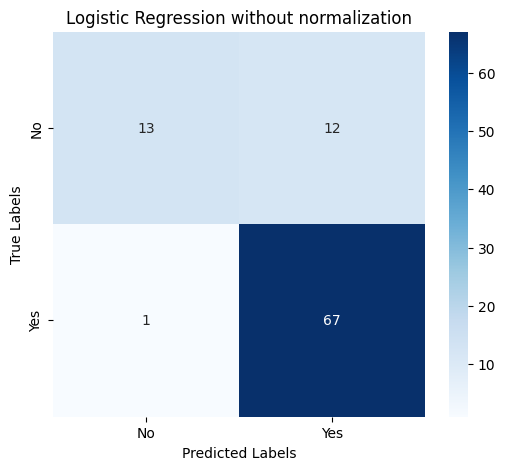

In [39]:
accuracy_LR = accuracy_score(y_test, y_pred_LR)
print(f"Accuracy: {accuracy_LR}")

precision_LR = precision_score(y_test, y_pred_LR)
print(f"Precision: {precision_LR}")

recall_LR = recall_score(y_test, y_pred_LR)
print(f"Recall: {recall_LR}")

f1_LR = f1_score(y_test, y_pred_LR)
print(f"F1-Score: {f1_LR}")

conf_matrix_LR = confusion_matrix(y_test, y_pred_LR)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_LR, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Logistic Regression without normalization')
plt.show()

Accuracy: 0.8494623655913979
Precision: 0.8375
Recall: 0.9852941176470589
F1-Score: 0.9054054054054055


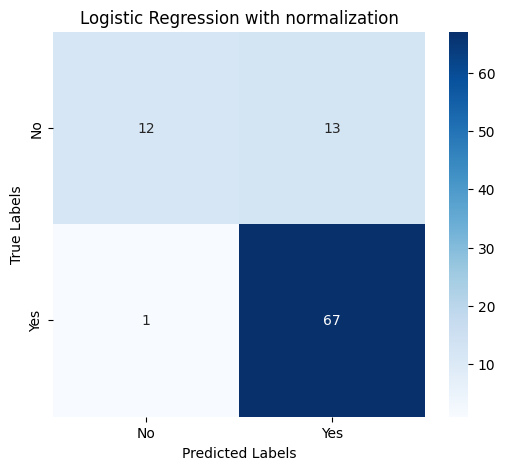

In [40]:
accuracy_LRn = accuracy_score(y_test, y_pred_LRn)
print(f"Accuracy: {accuracy_LRn}")

precision_LRn = precision_score(y_test, y_pred_LRn)
print(f"Precision: {precision_LRn}")

recall_LRn = recall_score(y_test, y_pred_LRn)
print(f"Recall: {recall_LRn}")

f1_LRn = f1_score(y_test, y_pred_LRn)
print(f"F1-Score: {f1_LRn}")

conf_matrix_LRn = confusion_matrix(y_test, y_pred_LRn)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_LRn, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Logistic Regression with normalization')
plt.show()

### KNN

In [41]:
y_pred_KNN = model_KNN_best.predict(X_test)
y_pred_KNNn = model_KNNn_best.predict(X_test)

Accuracy: 0.6881720430107527
Precision: 0.7241379310344828
Recall: 0.9264705882352942
F1-Score: 0.8129032258064516


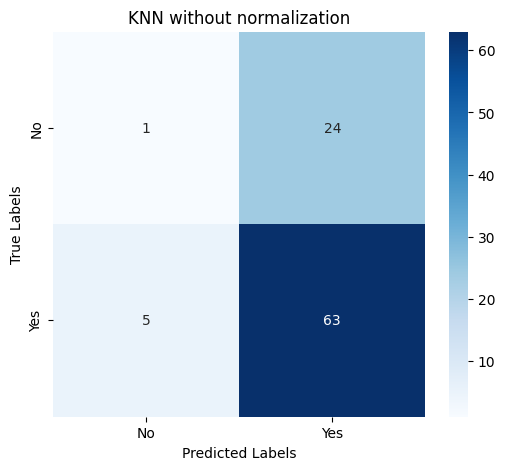

In [42]:
accuracy_KNN = accuracy_score(y_test, y_pred_KNN)
print(f"Accuracy: {accuracy_KNN}")

precision_KNN = precision_score(y_test, y_pred_KNN)
print(f"Precision: {precision_KNN}")

recall_KNN = recall_score(y_test, y_pred_KNN)
print(f"Recall: {recall_KNN}")

f1_KNN = f1_score(y_test, y_pred_KNN)
print(f"F1-Score: {f1_KNN}")

conf_matrix_KNN = confusion_matrix(y_test, y_pred_KNN)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_KNN, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('KNN without normalization')
plt.show()

Accuracy: 0.8279569892473119
Precision: 0.8170731707317073
Recall: 0.9852941176470589
F1-Score: 0.8933333333333334


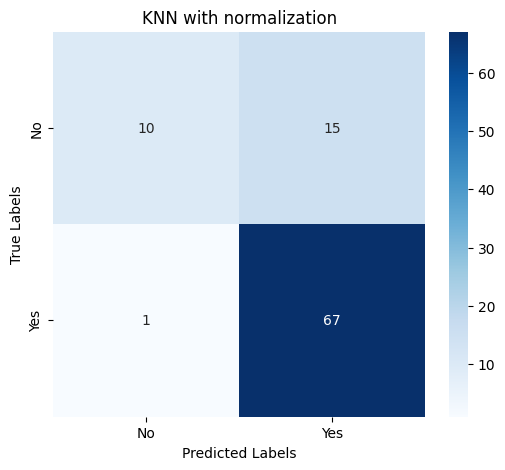

In [43]:
accuracy_KNNn = accuracy_score(y_test, y_pred_KNNn)
print(f"Accuracy: {accuracy_KNNn}")

precision_KNNn = precision_score(y_test, y_pred_KNNn)
print(f"Precision: {precision_KNNn}")

recall_KNNn = recall_score(y_test, y_pred_KNNn)
print(f"Recall: {recall_KNNn}")

f1_KNNn = f1_score(y_test, y_pred_KNNn)
print(f"F1-Score: {f1_KNNn}")

conf_matrix_KNNn = confusion_matrix(y_test, y_pred_KNNn)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_KNNn, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('KNN with normalization')
plt.show()

### ANN

In [44]:
y_pred_ANN = model_ANN_best.predict(X_test)
y_pred_ANNn = model_ANNn_best.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Accuracy: 0.8494623655913979
Precision: 0.8375
Recall: 0.9852941176470589
F1-Score: 0.9054054054054055


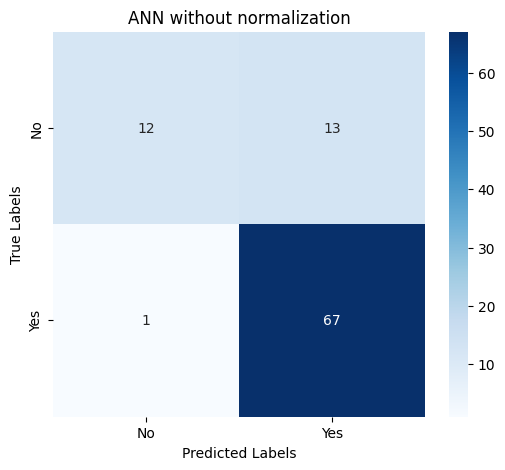

In [45]:
accuracy_ANN = accuracy_score(y_test, y_pred_ANN)
print(f"Accuracy: {accuracy_ANN}")

precision_ANN = precision_score(y_test, y_pred_ANN)
print(f"Precision: {precision_ANN}")

recall_ANN = recall_score(y_test, y_pred_ANN)
print(f"Recall: {recall_ANN}")

f1_ANN = f1_score(y_test, y_pred_ANN)
print(f"F1-Score: {f1_ANN}")

conf_matrix_ANN = confusion_matrix(y_test, y_pred_ANN)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_ANN, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('ANN without normalization')
plt.show()

Accuracy: 0.8494623655913979
Precision: 0.8375
Recall: 0.9852941176470589
F1-Score: 0.9054054054054055


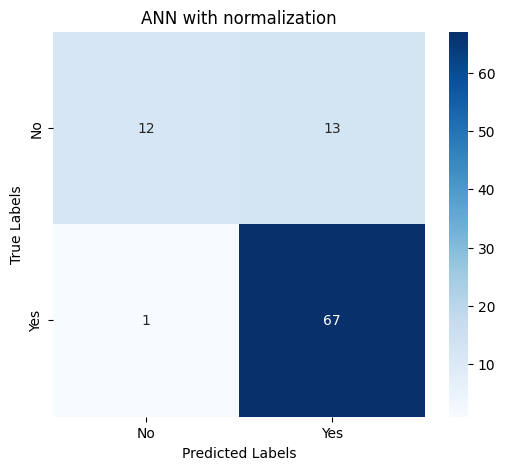

In [46]:
accuracy_ANNn = accuracy_score(y_test, y_pred_ANNn)
print(f"Accuracy: {accuracy_ANNn}")

precision_ANNn = precision_score(y_test, y_pred_ANNn)
print(f"Precision: {precision_ANNn}")

recall_ANNn = recall_score(y_test, y_pred_ANNn)
print(f"Recall: {recall_ANNn}")

f1_ANNn = f1_score(y_test, y_pred_ANNn)
print(f"F1-Score: {f1_ANNn}")

conf_matrix_ANNn = confusion_matrix(y_test, y_pred_ANNn)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_ANNn, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('ANN with normalization')
plt.show()

## Improve

To address this issue, we explore three approaches:  

1. **Boosting Methods**: We apply **GBM** and **AdaBoost** with **Decision Tree** and **Logistic Regression**, but they fail to bring significant improvements.  
2. **Support Vector Machine (SVM)**: We test an **SVM model**, but it also does not resolve the problem effectively.  
3. **OverSampling**: We attempt to balance the dataset by either **randomly increasing the number of 'No' class instances** or **generating synthetic data for the minority class**. We then retrain our models on the updated dataset.  

Finally, we observe that **Logistic Regression** performs significantly better in classifying the data accurately.

### Boosting

#### GBM

In [47]:
from sklearn.ensemble import GradientBoostingClassifier

In [48]:
model_GBM = Pipeline([
    ('preprocessor', non_numerical_coding),
    ('scaler', MinMaxScaler()),
    ('classifier', GradientBoostingClassifier())
])

param_grid_GBM = {
    "classifier__n_estimators" : [50, 100, 200],
    "classifier__learning_rate" : [0.01, 0.1, 0.2],
    "classifier__max_depth" : [3, 5, 7]
}

grid_GBM = GridSearchCV(model_GBM, param_grid=param_grid_GBM, cv=5)

grid_GBM.fit(X_train, y_train)

print(f"{grid_GBM.best_params_}")

model_GBM_best = grid_GBM.best_estimator_

{'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 50}


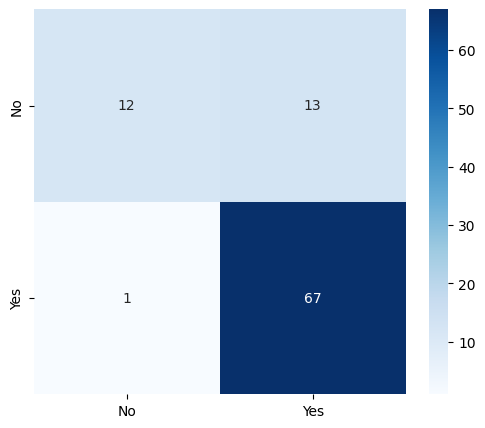

In [49]:
y_pred_GBM = model_GBM_best.predict(X_test)

conf_matrix_GBM = confusion_matrix(y_test, y_pred_GBM)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_GBM, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.show()

#### AdaBoost (DecisionTree)

In [50]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [51]:
model_Ada = Pipeline([
    ('preprocessor', non_numerical_coding),
    ('scaler', MinMaxScaler()),
    ('classifier', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), random_state=42))
])

param_grid_Ada = {
    "classifier__n_estimators": [50, 100, 200],  # تعداد مدل‌های ضعیف (درخت‌ها)
    "classifier__learning_rate": [0.01, 0.1, 1],  # نرخ یادگیری
    "classifier__base_estimator__max_depth": [1, 2, 3]  # عمق درخت تصمیم در AdaBoost
}

grid_Ada = GridSearchCV(model_Ada, param_grid=param_grid_Ada, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_Ada.fit(X_train, y_train)

print(f"AdaBoost best params: {grid_Ada.best_params_}")

model_Ada_best = grid_Ada.best_estimator_


Fitting 5 folds for each of 27 candidates, totalling 135 fits
AdaBoost best params: {'classifier__base_estimator__max_depth': 1, 'classifier__learning_rate': 0.01, 'classifier__n_estimators': 50}


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


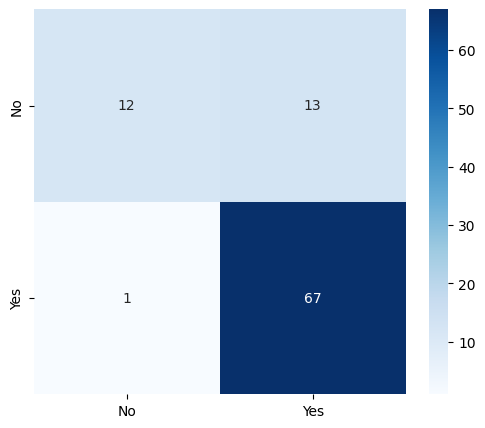

In [52]:
y_pred_Ada = model_Ada_best.predict(X_test)

conf_matrix_Ada = confusion_matrix(y_test, y_pred_Ada)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_Ada, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.show()

#### AdaBoost (LogisticRegression)

In [53]:
model_Ada_LR = Pipeline([
    ('preprocessor', non_numerical_coding),
    ('scaler', MinMaxScaler()),
    ('classifier', AdaBoostClassifier(base_estimator=LogisticRegression(), random_state=42))
])

param_grid_Ada_LR = {
    "classifier__n_estimators": [50, 100, 200],
    "classifier__learning_rate": [0.01, 0.1, 1],
    "classifier__base_estimator__C": [0.01, 0.1, 1, 10],
    "classifier__base_estimator__solver" : ['lbfgs', 'liblinear', 'sag', 'newton-cg'],
    "classifier__base_estimator__max_iter": [100, 200, 500]
}

grid_Ada_LR = GridSearchCV(model_Ada_LR, param_grid=param_grid_Ada_LR, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_Ada_LR.fit(X_train, y_train)

print(f"{grid_Ada_LR.best_params_}")

model_Ada_LR_best = grid_Ada_LR.best_estimator_


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


{'classifier__base_estimator__C': 0.1, 'classifier__base_estimator__max_iter': 100, 'classifier__base_estimator__solver': 'lbfgs', 'classifier__learning_rate': 1, 'classifier__n_estimators': 200}


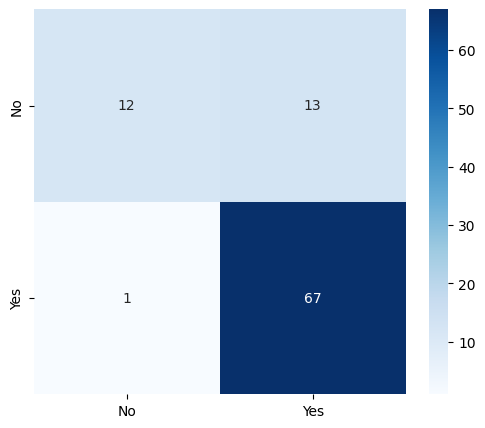

In [54]:
y_pred_Ada_LR = model_Ada_LR_best.predict(X_test)

conf_matrix_Ada_LR = confusion_matrix(y_test, y_pred_Ada_LR)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_Ada_LR, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.show()

### SVM (SVC)

In [55]:
from sklearn.svm import SVC

In [56]:
model_SVM = Pipeline([
    ('preprocessor', non_numerical_coding),
    ('scaler', MinMaxScaler()),
    ('classifier', SVC(class_weight='balanced'))
])

param_grid_SVM = {
    "classifier__C": [0.1, 1, 10, 100],
    "classifier__kernel": ['linear', 'rbf', 'poly'], 
    "classifier__gamma": ['scale', 'auto'],
    "classifier__degree": [3, 4, 5],
}

grid_SVM = GridSearchCV(model_SVM, param_grid=param_grid_SVM, cv=5)

grid_SVM.fit(X_train, y_train)

print(f"{grid_SVM.best_params_}")

model_SVM_best = grid_SVM.best_estimator_

{'classifier__C': 0.1, 'classifier__degree': 3, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}


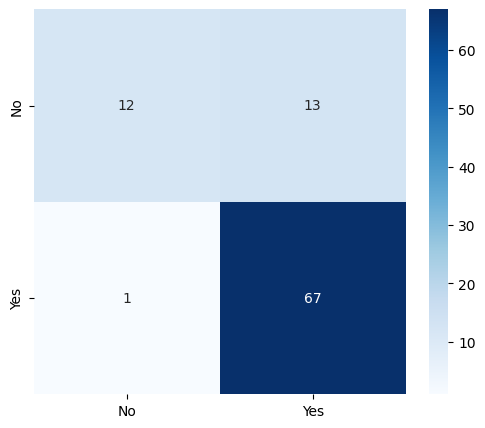

In [57]:
y_pred_SVM = model_SVM_best.predict(X_test)

conf_matrix_SVM = confusion_matrix(y_test, y_pred_SVM)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_SVM, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.show()

### OverSampling 

#### Random Oversampling

In [58]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

##### Logistic Regression

In [59]:
grid_LRn.fit(X_resampled, y_resampled)

model_LRn_RO_best = grid_LRn.best_estimator_

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached w

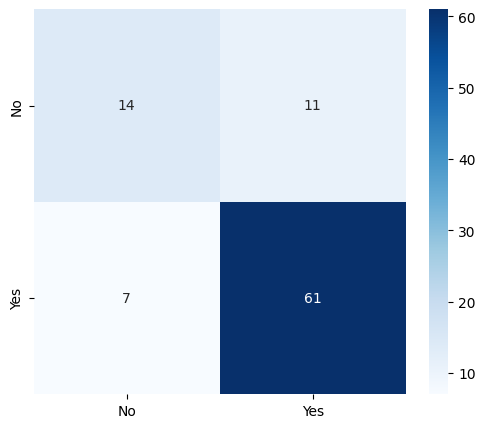

In [60]:
y_pred_LRn_RO= model_LRn_RO_best.predict(X_test)
conf_matrix_LRn_RO = confusion_matrix(y_test, y_pred_LRn_RO)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_LRn_RO, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.show()

##### KNN

In [61]:
grid_KNNn.fit(X_resampled, y_resampled)

model_KNNn_RO_best = grid_KNNn.best_estimator_

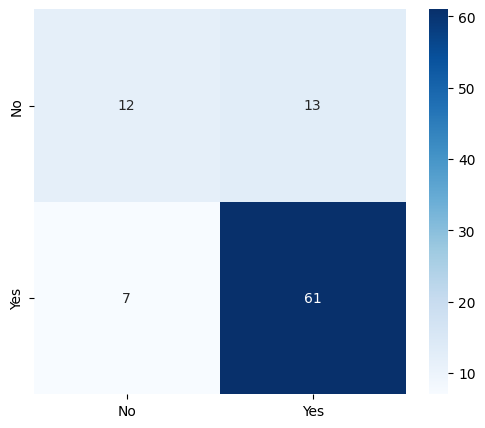

In [62]:
y_pred_KNNn_RO= model_KNNn_RO_best.predict(X_test)
conf_matrix_KNNn_RO = confusion_matrix(y_test, y_pred_KNNn_RO)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_KNNn_RO, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.show()

##### ANN

In [63]:
grid_ANNn.fit(X_resampled, y_resampled)

model_ANNn_RO_best = grid_ANNn.best_estimator_

Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7195
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6772
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6527
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6347
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6275
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5805
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5557
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5700
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5714
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5772
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5633
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5883
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5646
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5137
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5253
Epoch 16/50
36/36 ━━━━━━━━━━━━

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7636  
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7040
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6859
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6674
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6558
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6270
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6306
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6009
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5809
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5599
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5847
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5465
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5543
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5610
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5344
Epoch 16/50
36/36 ━━━━━━━━━━

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6983  
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6658
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6519
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6516
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6214
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6263
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5889
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5850
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5752
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5818
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5518
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5298
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5424
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5387
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5420
Epoch 16/50
36/36 ━━━━━━━━━━

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6918  
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6647
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6610
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6375
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6318
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6333
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5979
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5958
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5357
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5752
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5545
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5602
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5439
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5640
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5365
Epoch 16/50
36/36 ━━━━━━━━━━

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7020  
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6666
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6502
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6211
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6031
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5499
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5555
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5360
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5345
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5164
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5029
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5053
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5069
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5049
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5149
Epoch 16/50
36/36 ━━━━━━━━━━

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7748  
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6848
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6512
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6555
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6245
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6168
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6028
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5912
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5603
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5665
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5484
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5644
Epoch 13/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5354
Epoch 14/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5157
Epoch 15/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5165
Ep

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7091  
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6764
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6762
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6727
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6662
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6624
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6348
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6432
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6125
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5917
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5943
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5588
Epoch 13/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5737
Epoch 14/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5667
Epoch 15/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5505
Epoch 16/100
3

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6929  
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6771
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6681
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6538
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6491
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6210
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6255
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6217
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5848
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5474
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5745
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5472
Epoch 13/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5402
Epoch 14/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5535
Epoch 15/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5610
Epoch 16/100
3

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7074  
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6785
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6827
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6808
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6619
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6347
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6373
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6019
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5809
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5647
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5691
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5815
Epoch 13/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5310
Epoch 14/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5556
Epoch 15/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5208
Epoch 16/100
3

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6958  
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6594
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6145
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6337
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6082
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5922
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5849
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5918
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5717
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5445
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5474
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5227
Epoch 13/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5476
Epoch 14/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5437
Epoch 15/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5327
Epoch 16/100
3

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
Epoch 1/100
Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8108   
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7295 
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7020 
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6957 
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6867 
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6879 
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6780 
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6696 
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6720 
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6563 
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6550 
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6542 
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6396 
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6300 
Epoch 15/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6481 
Epoch 16/50
1

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7247   
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7070 
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6866 
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6817 
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6672 
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6705 
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6634 
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6401 
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6096 
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6148 
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6055 
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5900 
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5700 
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5582 
Epoch 15/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5522 
Epoch 16/50
1

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7062   
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6829 
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6706 
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6643 
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6406 
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6263 
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6240 
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5894 
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5759 
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5832 
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5794 
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5689 
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5467 
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5625 
Epoch 15/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5645 
Epoch 16/50
1

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6922   
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6727 
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6665 
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6444 
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6434 
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6369 
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6256 
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6016 
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6030 
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5681 
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5635 
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5652 
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5184 
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5692 
Epoch 15/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5723 
Epoch 16/50
1

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7283   
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7113 
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6960 
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6661 
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6693 
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6432 
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6530 
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6299 
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6350 
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6152 
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6053 
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5985 
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5972 
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5699 
Epoch 15/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5929 
Epoch 16/50
1

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6915
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6987 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6528 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6679 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6510 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6458 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6374 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6569 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6250 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6240 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6255 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6111 
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6016 
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5766 
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7043   
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6782 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6753 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6472 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6383 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6235 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6104 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6066 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5830 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5680 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5375 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5549 
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5465 
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5286 
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4980 

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6947   
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6666 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6600 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6461 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6189 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6415 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6158 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5959 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5919 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5601 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5867 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5580 
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5359 
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5236 
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5374 

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7075   
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6975 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6920 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6673 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6547 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6434 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6279 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6202 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6066 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6233 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6190 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5779 
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5956 
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5855 
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5684 

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6994   
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6839 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6645 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6565 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6478 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6603 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6320 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6020 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6106 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6038 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6183 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5613 
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5608 
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5625 
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5470 

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packag

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6821  
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6589
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6444
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6052
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5938
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5733
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5870
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5420
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5321
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5018
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5281
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5184
Epoch 13/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5005
Epoch 14/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5172
Epoch 15/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5277
Ep

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


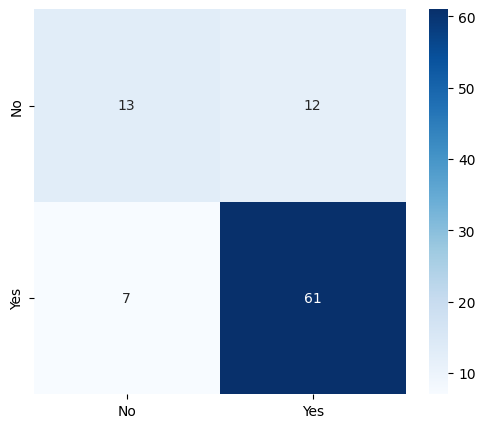

In [64]:
y_pred_ANNn_RO= model_ANNn_RO_best.predict(X_test)
conf_matrix_ANNn_RO = confusion_matrix(y_test, y_pred_ANNn_RO)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_ANNn_RO, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.show()

#### SMOTE

In [65]:
from imblearn.over_sampling import SMOTE
from collections import Counter

X_preprocessed = non_numerical_coding.fit_transform(X_train)
X_scaled = MinMaxScaler().fit_transform(X_preprocessed)

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_scaled, y_train)


##### Logistic Regression

In [66]:
grid_LRn.fit(X_resampled, y_resampled)

model_LRn_smote_best = grid_LRn.best_estimator_

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached w

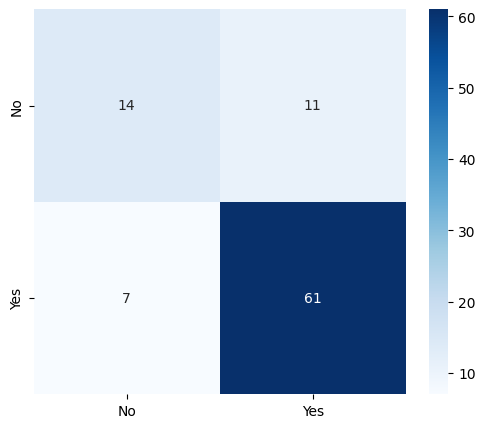

In [67]:
y_pred_LRn_smote= model_LRn_smote_best.predict(X_test)
conf_matrix_LRn_smote = confusion_matrix(y_test, y_pred_LRn_smote)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_LRn_smote, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.show()

##### KNN

In [68]:
grid_KNNn.fit(X_resampled, y_resampled)

model_KNNn_smote_best = grid_KNNn.best_estimator_



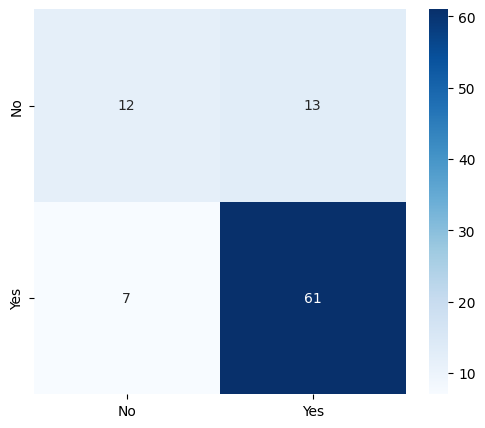

In [69]:
y_pred_KNNn_smote= model_KNNn_smote_best.predict(X_test)
conf_matrix_KNNn_smote = confusion_matrix(y_test, y_pred_KNNn_smote)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_KNNn_smote, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.show()

##### ANN

In [70]:
grid_ANNn.fit(X_resampled, y_resampled)

model_ANNn_smote_best = grid_ANNn.best_estimator_



Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7248  
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6861
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6797
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6659
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6506
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6233
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5943
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5861
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5823
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5612
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5049
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5386
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5524
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5108
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5221
Epoch 16/50
36/36 ━━━━━━━━━━

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6924  
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6613
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6494
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6325
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5795
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5620
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5361
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5455
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5499
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5160
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5178
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5100
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4959
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5235
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5126
Epoch 16/50
36/36 ━━━━━━━━━━

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7594
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6991
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6893
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6697
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6539
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6454
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6205
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6027
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6064
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5713
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5638
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5339
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5555
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5277
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5186
Epoch 16/50
36/36 ━━━━━━━━━━━━

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7075
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6816
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6734
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6521
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6601
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6513
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6389
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6012
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5926
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5760
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5593
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5641
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5132
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5703
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5228
Epoch 16/50
36/36 ━━━━━━━━━━━━

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7264
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6953
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6657
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6547
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6208
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5995
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5815
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5675
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5572
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5404
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5431
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5271
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5262
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5171
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5145
Epoch 16/50
36/36 ━━━━━━━━━━━━

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7134  
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6795
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6759
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6650
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6414
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6296
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6312
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5862
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6046
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5960
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5531
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5757
Epoch 13/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5453
Epoch 14/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5457
Epoch 15/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5479
Ep

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7439
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6950
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6634
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6230
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5814
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5673
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5211
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5352
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5431
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4991
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4955
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4976
Epoch 13/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4830
Epoch 14/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4805
Epoch 15/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4724
Epoch 16/100
36/

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6518
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6104
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6364
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5812
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5737
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5456
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5126
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5439
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5158
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5388
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5427
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5345
Epoch 13/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5274
Epoch 14/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5138
Epoch 15/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5126
Epoch 16/100
36/

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7191
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6805
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6647
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6422
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6177
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5904
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5937
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5607
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5389
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5271
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5327
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5358
Epoch 13/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5457
Epoch 14/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5197
Epoch 15/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5298
Epoch 16/100
36/

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6949
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6638
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6511
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6335
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6012
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5751
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5681
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5278
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5125
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5107
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5016
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5018
Epoch 13/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5294
Epoch 14/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5124
Epoch 15/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5380
Epoch 16/100
36/

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
Epoch 1/100
Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7244   
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7265 
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6923 
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6806 
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6708 
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6562 
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6552 
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6316 
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6405 
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6334 
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6125 
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6150 
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5799 
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6009 
Epoch 15/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5924 
Epoch 16/50
1

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7259   
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6914 
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6831 
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6748 
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6648 
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6395 
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6351 
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6272 
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6267 
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6059 
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5853 
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5868 
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5528 
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5741 
Epoch 15/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5332 
Epoch 16/50
1

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6990
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6754 
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6615 
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6639 
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6451 
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6182 
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6223 
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6055 
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5970 
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5878 
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5793 
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5590 
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5678 
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5539 
Epoch 15/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5614 
Epoch 16/50
18/1

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7115   
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6623 
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6706 
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6584 
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6410 
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6203 
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6167 
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6121 
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5964 
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5778 
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5809 
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5682 
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5450 
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5742 
Epoch 15/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5432 
Epoch 16/50
1

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7298   
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6816 
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6545 
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6549 
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6375 
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6308 
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6287 
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6107 
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6254 
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5994 
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5709 
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5926 
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5800 
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5456 
Epoch 15/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5813 
Epoch 16/50
1

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
Epoch 1/50


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7625   
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7151 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6995 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6836 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6838 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6737 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6640 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6599 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6529 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6537 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6253 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6286 
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6034 
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6134 
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - l

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6982
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6900 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6837 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6785 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6767 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6579 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6547 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6404 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6238 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6146 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6047 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5968 
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5998 
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5843 
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5615 
Ep

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7158
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6868 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6752 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6685 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6449 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6451 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6413 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6300 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6039 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6020 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6030 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5636 
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5619 
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5512 
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5632 
Ep

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7035
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6758  
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6685 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6478 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6396 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6261 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6121 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5930 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5787 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5668 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5775 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5557 
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5314 
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5420 
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5249 
E

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7015
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6698 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6639 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6438 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6302 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6289 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6100 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5893 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5744 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5781 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5685 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5512 
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5468 
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5137 
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5404 
Ep

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
Epoch 1/100


c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packag

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6882
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6725
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6559
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6460
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6073
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6255
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6048
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5937
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5631
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5288
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5424
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5592
Epoch 13/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5641
Epoch 14/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5471
Epoch 15/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5258
Epoc

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


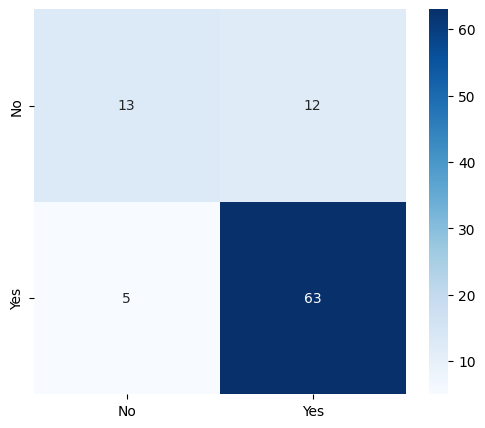

In [71]:
y_pred_ANNn_smote= model_ANNn_smote_best.predict(X_test)
conf_matrix_ANNn_smote = confusion_matrix(y_test, y_pred_ANNn_smote)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_ANNn_smote, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.show()

## compare models 

In this step, we move to the **test dataset** and attempt to predict the eligibility for loans using our top-performing models. Ultimately, we find that **Logistic Regression** (trained with oversampling) classifies a greater number of individuals as **ineligible for loans**, which aligns better with our goal.

### Read & DataCleaning

In [72]:
test_data = pd.read_csv('data\\test.csv')
test_data

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban
...,...,...,...,...,...,...,...,...,...,...,...
362,Male,Yes,3+,Not Graduate,Yes,4009,1777,113.0,360.0,1.0,Urban
363,Male,Yes,0,Graduate,No,4158,709,115.0,360.0,1.0,Urban
364,Male,No,0,Graduate,No,3250,1993,126.0,360.0,NaN,Semiurban
365,Male,Yes,0,Graduate,No,5000,2393,158.0,360.0,1.0,Rural


In [73]:
test_data.isnull().sum()

Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

In [74]:
#LoanAmount
test_data['LoanAmount'] = test_data['LoanAmount'].fillna(test_data['LoanAmount'].median())

#Loan_Amount_Term
test_data['Loan_Amount_Term'] = test_data['Loan_Amount_Term'].fillna(test_data['Loan_Amount_Term'].median())

#Dependents
test_data['Dependents'] = test_data['Dependents'].fillna(test_data['Dependents'].mode()[0])

#Self_Employed
test_data['Self_Employed'] = test_data['Self_Employed'].fillna(test_data['Self_Employed'].mode()[0])  

#Gender
test_data['Gender'] = test_data['Gender'].fillna(test_data['Gender'].mode()[0])

#Credit_History
test_data['Credit_History'] = test_data['Credit_History'].fillna(method='ffill')

C:\Users\eftekhari\AppData\Local\Temp\ipykernel_12868\3520196356.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_data['Credit_History'] = test_data['Credit_History'].fillna(method='ffill')


### compare

In [75]:
from collections import Counter

In [76]:
predict_LRn = model_LRn_best.predict(test_data)
count_LRn = Counter(predict_LRn)
df_LRn = pd.DataFrame.from_dict(count_LRn, orient='index', columns=['LRn'])

predict_KNNn = model_KNNn_best.predict(test_data)
count_KNNn = Counter(predict_KNNn)
df_KNNn = pd.DataFrame.from_dict(count_KNNn, orient='index', columns=['KNNn'])

predict_ANNn = model_ANNn_best.predict(test_data)
count_ANNn = Counter(predict_ANNn)
df_ANNn = pd.DataFrame.from_dict(count_ANNn, orient='index', columns=['ANNn'])

predict_LRn_RO = model_LRn_RO_best.predict(test_data)
count_LRn_RO = Counter(predict_LRn_RO)
df_LRn_RO = pd.DataFrame.from_dict(count_LRn_RO, orient='index', columns=['LRn_RO'])

predict_LRn_smote = model_LRn_smote_best.predict(test_data)
count_LRn_smote = Counter(predict_LRn_smote)
df_LRn_smote = pd.DataFrame.from_dict(count_LRn_smote, orient='index', columns=['LRn_smote'])

predict_ANNn_smote = model_ANNn_smote_best.predict(test_data)
count_ANNn_smote = Counter(predict_ANNn_smote)
df_ANNn_smote = pd.DataFrame.from_dict(count_ANNn, orient='index', columns=['ANNn_smote'])


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [77]:
df_combined = pd.concat([df_LRn, df_KNNn, df_ANNn, df_LRn_RO, df_LRn_smote, df_ANNn_smote], axis=1)
df_combined = df_combined.sort_index()
df_combined


,LRn,KNNn,ANNn,LRn_RO,LRn_smote,ANNn_smote
0,61,53,61,90,90,61
1,306,314,306,277,277,306
